In [18]:
import numpy as np
import pandas as pd
import xpress as xp
import matplotlib.pyplot as plt

In [2]:
# Load data
TransactionsInput = pd.read_excel("231013_Transactions_Input.xlsx")
FuardCases = pd.read_excel("231013_Fraud_Cases.xlsx")
CustomerBase = pd.read_excel("231013_Customer_Base.xlsx")

In [ ]:
# TransactionsInput
# FuardCases
# CustomerBase

## Data Pro-processing

1. Remove "cash withdraw" and "paid-in" transactions from `TransactionsInput` since

    - Banks have no responsibility when the funds are withdrawn at an ATM
    - Credit transactions (paid in) cannot be flagged as fraudulent in the current setup

2. Merge column "customer_prob" in `CustomerBase` to `TransactionInput_clean`

3. Create a new dataframe named `Investigation_time` which stores the time requirements for investigating different priority transactions, and merge column "investigation time" in `Investigation_time` to `TransactionInput_clean` 

In [7]:
# Remove "cash withdraw" and "pain-in" transactions
TransactionsInput_clean = TransactionsInput.drop(TransactionsInput[
    (TransactionsInput['category'] == 'Cash Withdraw') | 
    (TransactionsInput['In_or_Out'] == 'paid_in')
    ].index)

# Merge column "customer_prob"
TransactionsInput_clean = pd.merge(TransactionsInput_clean, CustomerBase, on='customer_id', how='left')

# Create a dataframe of the investigation time
Investigation_time = pd.DataFrame(data={'priority':[1, 2, 3, 4], 'investigation time':[0.25, 0.5, 1, 2]}, index=[0, 1, 2, 3])
# print(Investigation_time)

# Merge column "investigation time"
TransactionsInput_clean = pd.merge(TransactionsInput_clean, Investigation_time, on='priority', how='left')

TransactionsInput_clean.head()

,transaction_id,description,Amount,category,date,month,customer_id,type,In_or_Out,bank_to,bank_from,transac_prob,description_prob,priority,home_bank,customer_prob,investigation time
0,2,Online Retailer - Electronics Purchase,199.99,Online Shopping,2023-10-01,October,10298,spending,paid_out,bank_A,bank_E,0.78,0.25,3,bank_E,0.49,1.00
1,3,Utilities Payment - Internet Service,60.00,Utilities,2023-10-01,October,10298,spending,paid_out,bank_C,bank_E,0.30,0.22,1,bank_E,0.49,0.25
2,4,Rent Payment,1500.00,Housing,2023-10-01,October,14507,spending,paid_out,bank_D,bank_E,0.57,0.53,3,bank_E,0.35,1.00
3,6,Online Retailer - Electronics Purchase,299.99,Online Shopping,2023-10-01,October,14507,spending,paid_out,bank_E,bank_E,0.75,0.65,3,bank_E,0.35,1.00
4,7,Asos - Online Fashion Shopping,55.00,Shopping,2023-10-01,October,14507,spending,paid_out,bank_B,bank_E,0.37,0.31,1,bank_E,0.35,0.25


## Data Visualisation

### 3. Common differences between fraud and non-fraud transactions

1. Merge the `FraudCases` data with `TransactionsInput` according to the corresponding "transaction_id"
    - Only a number of transactions in `TransactionsInput` are identified as fraud, whose "is_scam_transaction" value is set to 1. The other transactions that are not identified as fraud should be set to 0 manually.
    - Fraud transactions has specific "fraud_type". Non-fraud transactions are set to "NaN" automatically.
    - Fraud transactions has specific "case_id". Non-fraud transactions are set to "NaN" automatically.

2. Count the total number of fraud and non-fraud transactions
    - Use histogram to show the difference.

3. Calculate the average Amount amount of fraud and nonfraud transactions constraint to
    - No constraint (consider all the transactions)
    - "type", and further "category" (bar chart for comparison)
    - "bank_to", and further "bank_from"

In [57]:
# Merge
TF = pd.merge(TransactionsInput, FuardCases, on='transaction_id', how='left')
TF['is_scam_transaction'].fillna(0, inplace=True)
TF.head()

,transaction_id,description,Amount,category,date,month,customer_id,type,In_or_Out,bank_to,bank_from,transac_prob,description_prob,priority,is_scam_transaction,fraud_type,case_id
0,1,Salary Deposit - XYZ Corporation,11474.33021,Income,2023-10-01,October,17699,income,paid_in,bank_A,bank_A,NaN,NaN,3,0.0,NaN,NaN
1,2,Online Retailer - Electronics Purchase,199.99000,Online Shopping,2023-10-01,October,10298,spending,paid_out,bank_A,bank_E,0.78,0.25,3,0.0,NaN,NaN
2,3,Utilities Payment - Internet Service,60.00000,Utilities,2023-10-01,October,10298,spending,paid_out,bank_C,bank_E,0.30,0.22,1,0.0,NaN,NaN
3,4,Rent Payment,1500.00000,Housing,2023-10-01,October,14507,spending,paid_out,bank_D,bank_E,0.57,0.53,3,0.0,NaN,NaN
4,5,Paycheck Deposit - Company Name,10480.68449,Income,2023-10-01,October,14507,income,paid_in,bank_E,bank_D,NaN,NaN,3,0.0,NaN,NaN


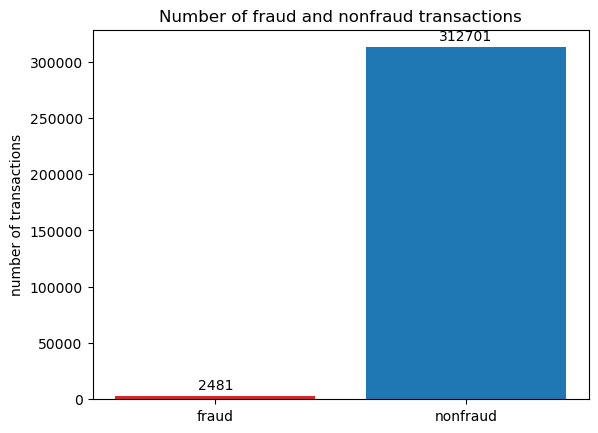

In [58]:
# Count the number of fraud and non-fraud transactions
count_fraud = (TF['is_scam_transaction'] == 1).sum()
count_nonfraud = (TF['is_scam_transaction'] == 0).sum()
count_fraud, count_nonfraud

fig, ax = plt.subplots()

transactions = ['fraud', 'nonfraud']
counts = [count_fraud, count_nonfraud]
bar_labels = ['fraud', 'nonfraud']
bar_colors = ['tab:red', 'tab:blue']

bars = ax.bar(transactions, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Number of Transactions')
ax.set_title('Number of fraud and nonfraud transactions')

# Adding the count above the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

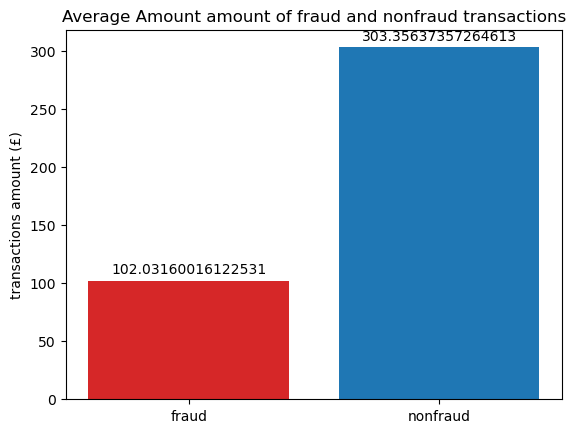

In [59]:
# Calculate the average Amount amount of all fraud and nonfraud transactions
average_transaction_amount_fraud = TF[TF['is_scam_transaction'] == 1]['Amount'].mean()
average_transaction_amount_nonfraud = TF[TF['is_scam_transaction'] == 0]['Amount'].mean()
average_transaction_amount_fraud, average_transaction_amount_nonfraud

fig, ax = plt.subplots()

transactions = ['fraud', 'nonfraud']
counts = [average_transaction_amount_fraud, average_transaction_amount_nonfraud]
bar_labels = ['fraud', 'nonfraud']
bar_colors = ['tab:red', 'tab:blue']

bars = ax.bar(transactions, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Average Transaction Amount (£)')
ax.set_title('Average Amount amount of fraud and nonfraud transactions')

# Adding the count above the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

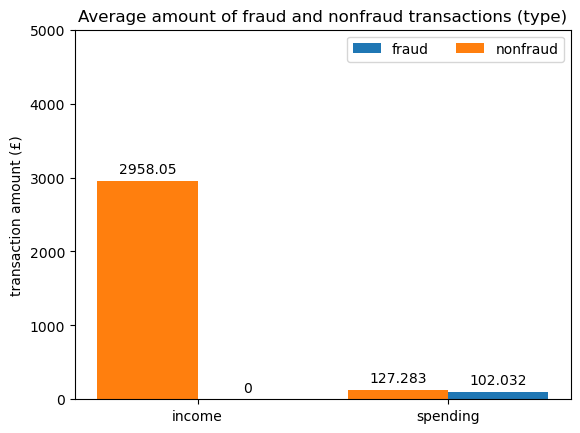

In [60]:
# Calculate the average Amount amount of fraud and nonfraud transactions (type)
average_fraud_income = TF[(TF['is_scam_transaction'] == 1) & (TF['type'] == 'income')]['Amount'].mean()
average_fraud_spending = TF[(TF['is_scam_transaction'] == 1) & (TF['type'] == 'spending')]['Amount'].mean()
average_nonfraud_income = TF[(TF['is_scam_transaction'] == 0) & (TF['type'] == 'income')]['Amount'].mean()
average_nonfraud_spending = TF[(TF['is_scam_transaction'] == 0) & (TF['type'] == 'spending')]['Amount'].mean()

type = ("income", "spending")
average_amount = {
    'fraud': (average_fraud_income, average_fraud_spending),
    'nonfraud': (average_nonfraud_income, average_nonfraud_spending)
}

x = np.arange(len(type))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0.5 

fig, ax = plt.subplots()

for transaction, avg in average_amount.items():
    # Replace NaN with 0 for plotting purposes
    avg = [0 if np.isnan(x) else x for x in avg]
    offset = width * multiplier
    rects = ax.bar(x + offset, avg, width, label=transaction)
    ax.bar_label(rects, padding=3)
    multiplier -= 1

# Add some text for labels, title and custom x-axis tick labels. etc.
ax.set_ylabel('Average Transaction Amount (£)')
ax.set_title('Average amount of fraud and nonfraud transactions (type)')
ax.set_xticks(x, type)
ax.legend(loc="upper right", ncols=2)
ax.set_ylim(0, 5000)

plt.show()

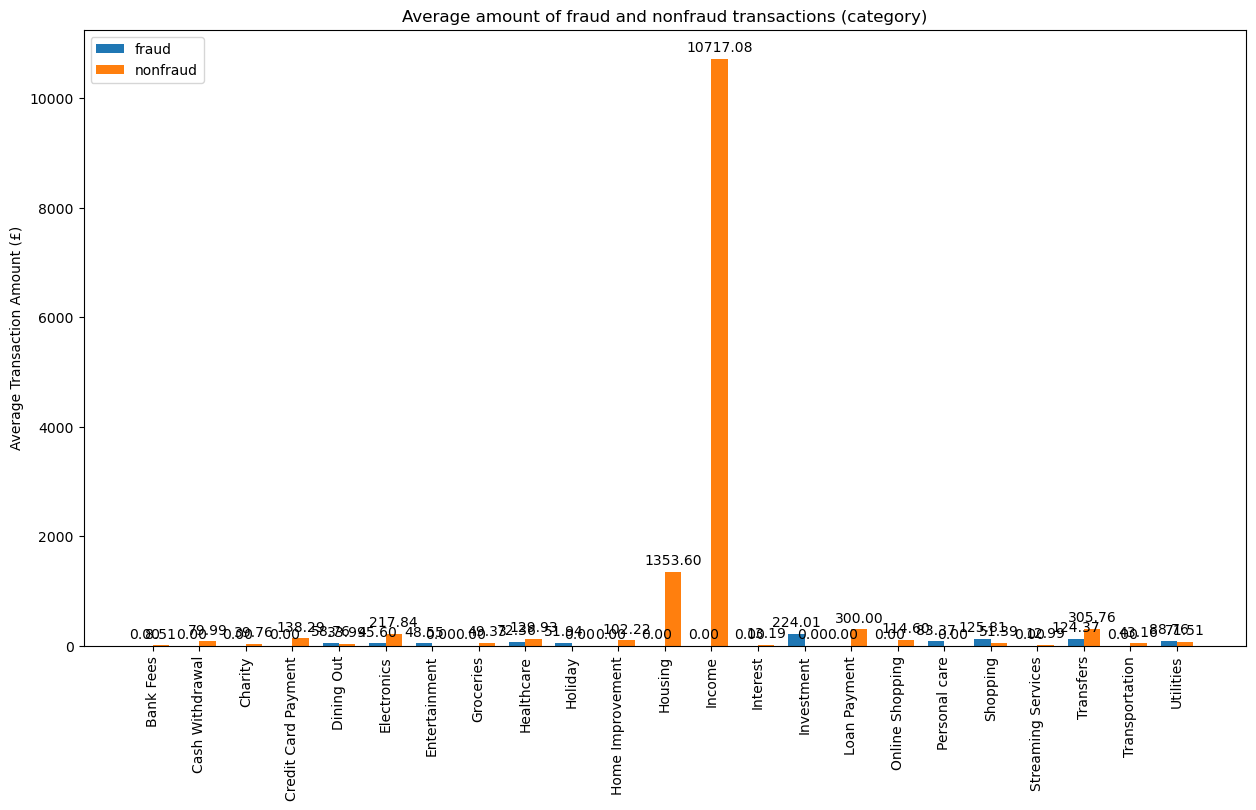

In [70]:
# Calculate the average Amount amount of fraud and nonfraud transactions (category)
# Initialise two dictionaries to store average amount of fraud and nonfraud for each category
avg_amount_fraud = {}
avg_amount_nonfraud = {}

# Loop through each unique category to calculate the average transaction amount
for category in TF['category'].unique():
    # Filter fraud and nonfraud with the current category
    fraud_in_category = TF[(TF['is_scam_transaction'] == 1) & (TF['category'] == category)]
    nonfraud_in_category = TF[(TF['is_scam_transaction'] == 0) & (TF['category'] == category)]
    # Calculate the average transaction amount for the fraud/nonfraud in this category
    avg_fraud_value = fraud_in_category['Amount'].mean()
    avg_nonfraud_value = nonfraud_in_category['Amount'].mean()
    # Store the result in the dictionaries
    avg_amount_fraud[category] = avg_fraud_value
    avg_amount_nonfraud[category] = avg_nonfraud_value

# Categories for x-axis
categories = sorted(avg_amount_fraud.keys())

# Values for y-axis
fraud_values = [avg_amount_fraud[category] for category in categories]
nonfraud_values = [avg_amount_nonfraud[category] for category in categories]

# Replace NaN with 0 for plotting purposes
fraud_values = [0 if np.isnan(x) else x for x in fraud_values]
nonfraud_values = [0 if np.isnan(x) else x for x in nonfraud_values]

x = np.arange(len(categories)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting fraud bars
fraud_bars = ax.bar(x - width/2, fraud_values, width, label='fraud')

# Plotting nonfraud bars
nonfraud_bars = ax.bar(x + width/2, nonfraud_values, width, label='nonfraud')

# Adding labels and title
ax.set_ylabel('Average Transaction Amount (£)')
ax.set_title('Average amount of fraud and nonfraud transactions (category)')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=90) # Rotate category labels to fit
ax.legend(loc='upper left')

# Function to add value labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
# Call function to add labels to the bars
add_labels(fraud_bars)
add_labels(nonfraud_bars)

plt.show()

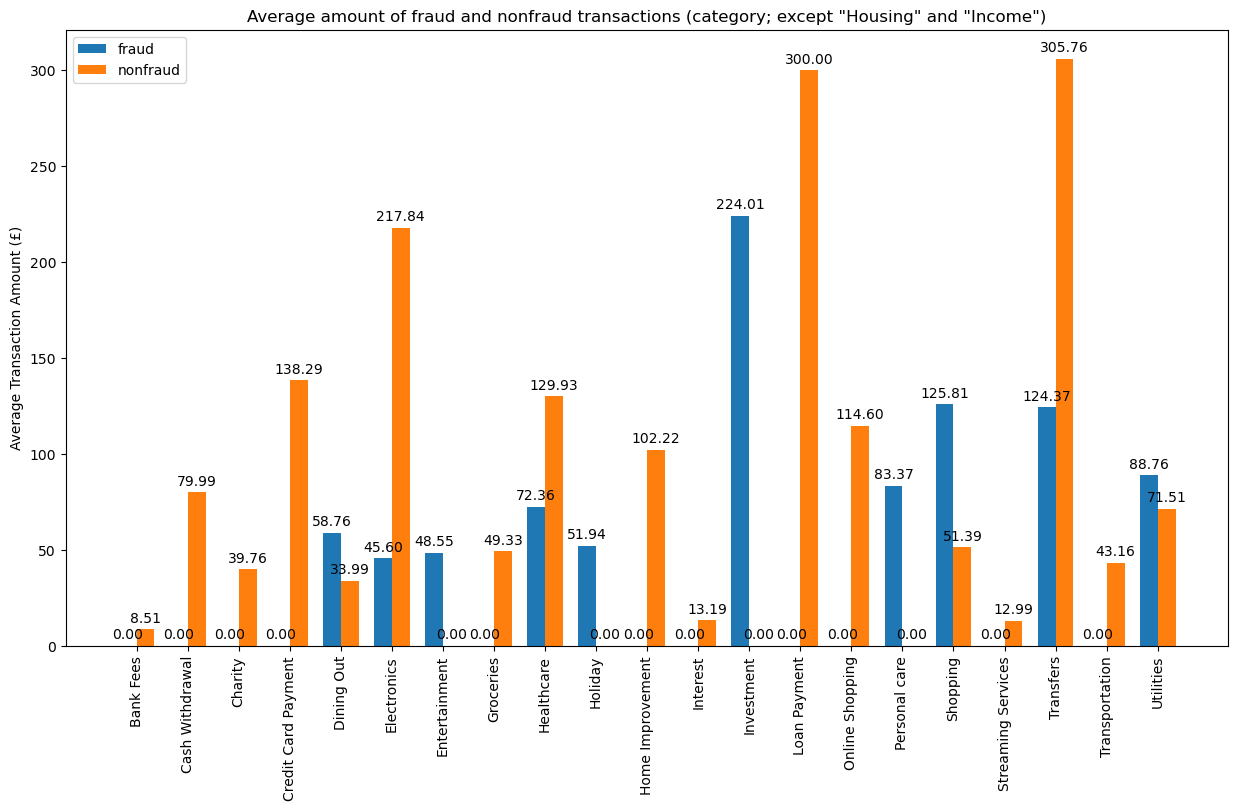

In [71]:
# Calculate the average Amount amount of fraud and nonfraud transactions (category; except "Housing" and "Income")
# Calculate the average Amount amount of fraud and nonfraud transactions (category)
# Initialise two dictionaries to store average amount of fraud and nonfraud for each category
avg_amount_fraud = {}
avg_amount_nonfraud = {}

# Loop through each unique category to calculate the average transaction amount
for category in TF['category'].unique():
    if (category != 'Housing') & (category != 'Income'):
        # Filter fraud and nonfraud with the current category
        fraud_in_category = TF[(TF['is_scam_transaction'] == 1) & (TF['category'] == category)]
        nonfraud_in_category = TF[(TF['is_scam_transaction'] == 0) & (TF['category'] == category)]
        # Calculate the average transaction amount for the fraud/nonfraud in this category
        avg_fraud_value = fraud_in_category['Amount'].mean()
        avg_nonfraud_value = nonfraud_in_category['Amount'].mean()
        # Store the result in the dictionaries
        avg_amount_fraud[category] = avg_fraud_value
        avg_amount_nonfraud[category] = avg_nonfraud_value

# Categories for x-axis
categories = sorted(avg_amount_fraud.keys())

# Values for y-axis
fraud_values = [avg_amount_fraud[category] for category in categories]
nonfraud_values = [avg_amount_nonfraud[category] for category in categories]

# Replace NaN with 0 for plotting purposes
fraud_values = [0 if np.isnan(x) else x for x in fraud_values]
nonfraud_values = [0 if np.isnan(x) else x for x in nonfraud_values]

x = np.arange(len(categories)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting fraud bars
fraud_bars = ax.bar(x - width/2, fraud_values, width, label='fraud')

# Plotting nonfraud bars
nonfraud_bars = ax.bar(x + width/2, nonfraud_values, width, label='nonfraud')

# Adding labels and title
ax.set_ylabel('Average Transaction Amount (£)')
ax.set_title('Average amount of fraud and nonfraud transactions (category; except "Housing" and "Income")')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=90) # Rotate category labels to fit
ax.legend(loc='upper left')

# Function to add value labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
# Call function to add labels to the bars
add_labels(fraud_bars)
add_labels(nonfraud_bars)

plt.show()

In [ ]:
# Find seasonal pattern
Fuard_time =
